In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from __future__ import unicode_literals

In [4]:
import sys
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib
import pandas as pd
import toolz

%aimport classifier

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('font', family='Arial')
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [6]:
from toolz.curried import map
from toolz.functoolz import pipe
from toolz.itertoolz import unique

In [7]:
recast_path = './recast_class/dartmouth/'
recastd_path = './recastd_class/dartmouth/'
trace = 'Dartmouth'

In [8]:
p_rnd = [1e-6, 1e-5, 1e-4, 1e-3,]

In [9]:
def build_graph(fname):  
    return nx.parse_edgelist (
        open(fname, 'r'),
        nodetype=int, 
        data=(('class', int),),
        create_using=nx.Graph()
    )

This reads the files generated by *offline* recast 

base3 is the graph with the class assigned by recast when using $p_{rnd} = 10^{-3}$

In [10]:
base3 = build_graph(recast_path + os.sep + '0.001.txt')   # 10^-3
base4 = build_graph(recast_path + os.sep + '0.0001.txt')  # 10^-4
base5 = build_graph(recast_path + os.sep + '1e-05.txt')   # ...
base6 = build_graph(recast_path + os.sep + '1e-06.txt')

List every file in recastd directory. The first number is the node id and the second is the $p_{rnd}$ value used
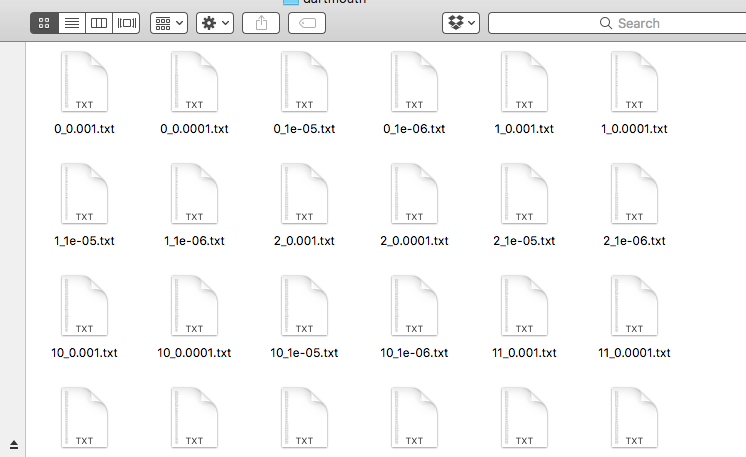

See **gen_edgelist** to see how I generate these files

In [11]:
recastd_files = list(pipe(
    os.listdir(recastd_path),
    map(lambda x: x.strip('.txt').split('_')[0]),
    unique,
))

In [12]:
# acertos = dict.fromkeys(map(str, p_rnd), 0)
# erros = dict.fromkeys(map(str, p_rnd), 0)

classifier*x* is a dict (edge -> class) that stores the class given by recastd for an edge

For instance, $classifier3[(1, 2)]$ = $\textbf{friends}$ means that recast**d** assigned the class **friends** for the pair $(1, 2)$ in the ego graph induced by $1$ when using $p_{rnd} = 10^{-3}$

It's valid to say that the classification is not symmetric. The class of $(x, y)$ is not always the same as $(y, x)$. This is because every node creates it's own ego graph. 

In [13]:
classifier3 = dict()
classifier4 = dict()
classifier5 = dict()
classifier6 = dict()

For every edge in each graph, store the class for that edge according to the $p_{rnd}$ value used.

In [14]:
def map_values(node, cls, graph):
    for j in graph.neighbors_iter(node):
        cls[(node, j)] = graph.get_edge_data(node, j)['class']

In [15]:
for r in recastd_files:
    graph3 = build_graph(recastd_path + os.sep + r + '_0.001.txt')
    graph4 = build_graph(recastd_path + os.sep + r + '_0.0001.txt')
    graph5 = build_graph(recastd_path + os.sep + r + '_1e-05.txt')
    graph6 = build_graph(recastd_path + os.sep + r + '_1e-06.txt')

    map_values (int(r), classifier3, graph3)
    map_values (int(r), classifier4, graph4)
    map_values (int(r), classifier5, graph5)
    map_values (int(r), classifier6, graph6)

# Optimal Classification

For every class (friends, bridges, ...) and for every $p_{rnd}$, I compute the number of optimal classifications. 

A classification is said to be optimal if for a pair of nodes $(x, y)$ the class assigned by *recast* is the same assigned by *recastd* on ego_graph$(x)$ and on ego_graph$(y)$

In [16]:
def classificacao_otima (cls, base):
    opt = dict()
    opt[classifier.friends] = 0
    opt[classifier.bridges] = 0
    opt[classifier.acquaintance] = 0
    opt[classifier.random] = 0
    
    for (x, y) in cls.iterkeys():
        assert (base.has_edge(x, y))
        c1 = cls[(x, y)]
        c2 = cls[(y, x)]
        if base.get_edge_data(x, y)['class'] == c1 == c2:
            opt[c1] += 1
    return opt

In [17]:
otimo3 = classificacao_otima (classifier3, base3)
otimo3

{0: 49764, 2: 4, 3: 0, 4: 6444}

In [18]:
otimo4 = classificacao_otima (classifier4, base4)
otimo4

{0: 53040, 2: 4, 3: 0, 4: 6668}

In [19]:
otimo5 = classificacao_otima (classifier5, base5)
otimo5

{0: 55796, 2: 2, 3: 0, 4: 6972}

In [20]:
otimo6 = classificacao_otima (classifier6, base6)
otimo6

{0: 58076, 2: 2, 3: 0, 4: 7178}

### pandas analysis

In [166]:
df = pd.DataFrame.from_dict ({
    '$10^{-3}$': otimo3,
    '$10^{-4}$': otimo4,
    '$10^{-5}$': otimo5,
    '$10^{-6}$': otimo6,
})

df = df.transpose()
df.columns = ['Random', 'Friends', 'Acquaintance', 'Bridges']

In [168]:
df['sum'] = df.sum(axis=1)
df = df.loc[:, 'Random':'Bridges'].div(df['sum'], axis=0)
df

,Random,Friends,Acquaintance,Bridges
$10^{-3}$,0.442646,0.000036,0.0,0.057319
$10^{-4}$,0.444132,0.000033,0.0,0.055835
$10^{-5}$,0.444448,0.000016,0.0,0.055536
$10^{-6}$,0.444986,0.000015,0.0,0.054999


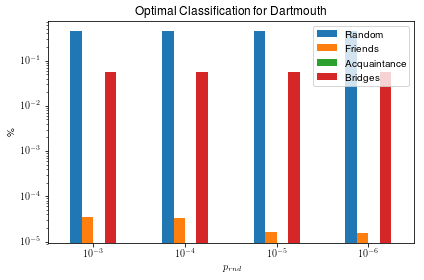

In [173]:
ax = df.plot(kind='bar', 
        logy=True, 
        title='Optimal Classification for {}'.format(trace),
        rot=0)

ax.set_ylabel('\%')
ax.set_xlabel('$p_{rnd}$')

From the plot above, we see that most of the optimal classifications are to *random* and *bridges* classes

This is expected when nodes don't share their graph in an encounter. The reason is that $p_{rnd}$ is calculated in the random counter part of each ego graph and they are pratically the same

### To where the classes are going?

In [25]:
classes = {
    'friends': classifier.friends,
    'bridges': classifier.bridges,
    'acquaintance': classifier.acquaintance,
    'random': classifier.random,
}

In [26]:
def count_classification (cls, base):
    
    def map_classes (c):
        return {
            0: 'random',
            2: 'friends',
            3: 'acquaintance',
            4: 'bridges',
        }[c]
    
    opt = {
        'friends': {k: 0 for k in classes.keys()},
        'bridges': {k: 0 for k in classes.keys()},
        'acquaintance': {k: 0 for k in classes.keys()},
        'random': {k: 0 for k in classes.keys()},
    }
    for (x, y) in cls.iterkeys():
        assert (base.has_edge(x, y))
        
        c0 = map_classes(base.get_edge_data(x, y)['class'])
        c1 = map_classes(cls[(x, y)])
        c2 = map_classes(cls[(y, x)])
        opt[c0][c1] += 1
        opt[c0][c2] += 1
    return opt

##### For each $p_{rnd}$...

In [128]:
def build_table(classifier, base):
    w = count_classification(classifier, base)
    df = pd.DataFrame.from_dict(w)
    df.columns = ['Recast Acquaintance', 'Recast Bridges', 'Recast Friends', 'Recast Random']
    df = df.transpose()
    df.columns = ['RD Acquaintance', 'RD Bridges', 'RD Friends', 'RD Random']
    
    # taking percentage
    df['sum'] = df.sum(axis=1)
    df = df.loc[:, 'RD Acquaintance':'RD Random'].div(df['sum'], axis=0)
    return df

##### for base3

In [129]:
df3 = build_table(classifier3, base3)

In [131]:
df3

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.000000,0.000000,0.000000,1.000000
Recast Bridges,0.000717,0.375996,0.000558,0.622728
Recast Friends,0.001406,0.317801,0.001374,0.679418
Recast Random,0.000000,0.000000,0.000000,1.000000


In the table above, The first column of each row represents the class assigned by Recast and the header (first row) is the class assigned by **Distributed Recast**. For instance, if an edge $(x, y)$ is marked as *friends* by Recast and *Acquaintance* by Distributed Recast, then we count $+1$ in the table[Recast friends][RD Acquaintance]

Note that we're are counting the same edge twice $(x, y)$ and $(y, x)$

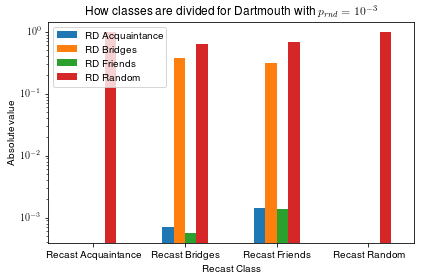

In [149]:
ax = df3.plot(kind='bar', 
              title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-3}$',
              logy=True, 
              rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('Absolute value')

##### for base4

In [134]:
df4 = build_table(classifier4, base4)

In [135]:
df4

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.000000,0.000000,0.000000,1.000000
Recast Bridges,0.000791,0.379934,0.000554,0.618722
Recast Friends,0.001688,0.244676,0.001728,0.751909
Recast Random,0.000000,0.000000,0.000000,1.000000


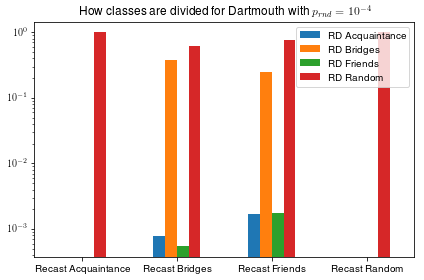

In [147]:
df4.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-4}$',
         logy=True,
         rot=0)

##### for base5

In [137]:
df5 = build_table(classifier5, base5)

In [138]:
df5

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.000000,0.000060,0.000060,0.999880
Recast Bridges,0.000900,0.408719,0.000573,0.589809
Recast Friends,0.001994,0.270193,0.002044,0.725768
Recast Random,0.000000,0.000000,0.000000,1.000000


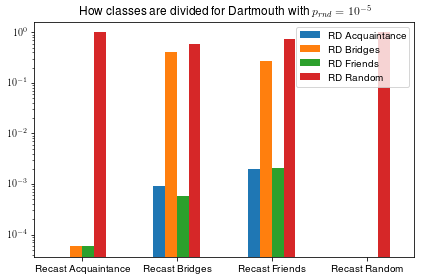

In [146]:
df5.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-5}$',
         logy=True,
         rot=0)

##### for base6

In [141]:
df6 = build_table(classifier6, base6)

In [142]:
df6

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.000000,0.000195,0.000056,0.999749
Recast Bridges,0.000977,0.435419,0.000594,0.563010
Recast Friends,0.002405,0.317341,0.002528,0.677726
Recast Random,0.000000,0.000121,0.000000,0.999879


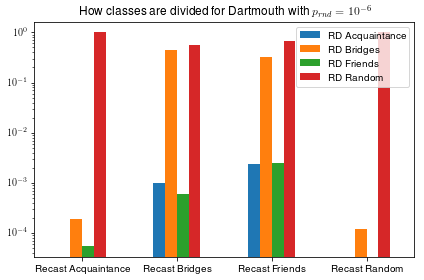

In [145]:
df6.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-6}$',
         logy=True,
         rot=0)